# Static GCN Baseline

Trains a 2-layer GCN on graph snapshots at different observation windows.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_observation_window_graphs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm.notebook import tqdm

torch.manual_seed(42)
np.random.seed(42)

## Configuration

In [4]:
CONFIG = {
    'data_dir': '../elliptic_dataset',
    'train_timesteps': (5, 29),
    'val_timesteps': (30, 33),
    'test_timesteps': (34, 42),
    'observation_windows': [0, 3, 5, 7],
    'hidden_dim': 64,
    'dropout': 0.5,
    'learning_rate': 0.01,
    'weight_decay': 5e-4,
    'epochs': 200,
    'patience': 20,
    'device': 'mps'
}

print(f"Device: {CONFIG['device']}")

Device: mps


## Load Data

In [5]:
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../graph_cache',
    use_cache=True,
    verbose=False
)

split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

print(f"Train: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")

Train: 109133 nodes
Val:   16718 nodes
Test:  50876 nodes


## Prepare Graphs

In [6]:
device = torch.device(CONFIG['device'])

graphs = prepare_observation_window_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=device
)


PREPARING OBSERVATION WINDOW GRAPHS

Split boundaries:
  Train: first_appearance <= 29
  Val:   first_appearance <= 33
  Test:  first_appearance <= 42

Observation windows: K = [0, 3, 5, 7]

K = 0 (Observe nodes for 0 timesteps after first appearance)

TRAIN split:
  Split period: nodes with first_appearance <= 29
  Evaluation time: t = 29 + 0 = 29
  Building graph at t=29...
  Graph: 474,120 nodes, 1,510,474 edges
  Eval nodes: 109,133 (23.02% of graph)
    Licit: 101,896 (93.4%)
    Illicit: 7,237 (6.6%)

VAL split:
  Split period: nodes with first_appearance <= 33
  Evaluation time: t = 33 + 0 = 33
  Building graph at t=33...
  Graph: 521,595 nodes, 1,787,166 edges
  Eval nodes: 16,718 (3.21% of graph)
    Licit: 15,413 (92.2%)
    Illicit: 1,305 (7.8%)

TEST split:
  Split period: nodes with first_appearance <= 42
  Evaluation time: t = 42 + 0 = 42
  Building graph at t=42...
  Graph: 697,242 nodes, 2,215,839 edges
  Eval nodes: 50,876 (7.30% of graph)
    Licit: 47,658 (93.7%)
  

## Model Definition

In [7]:
class StaticGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## Training Functions

In [8]:
def train_epoch(model, data, mask, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    logits = model(data.x, data.edge_index)
    loss = criterion(logits[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        pred = logits[mask].argmax(dim=1)
        acc = (pred == data.y[mask]).float().mean().item()
    
    return loss.item(), acc


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits[mask].argmax(dim=1).cpu().numpy()
        true = data.y[mask].cpu().numpy()
        probs = F.softmax(logits[mask], dim=1)[:, 1].cpu().numpy()
        
        acc = accuracy_score(true, pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true, pred, average='binary', pos_label=1, zero_division=0
        )
        auc = roc_auc_score(true, probs) if len(np.unique(true)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

## Train Models

In [9]:
results = {}
models = {}

for K in CONFIG['observation_windows']:
    print(f"\n{'='*70}")
    print(f"Training with K={K}")
    print('='*70)
    
    train_data = graphs[K]['train']
    val_data = graphs[K]['val']
    test_data = graphs[K]['test']
    
    # Initialize model
    num_features = train_data.x.shape[1]
    model = StaticGCN(
        num_features=num_features,
        hidden_dim=CONFIG['hidden_dim'],
        num_classes=2,
        dropout=CONFIG['dropout']
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    # Class weights
    train_labels = train_data.y[train_data.eval_mask]
    class_counts = torch.bincount(train_labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Training loop
    best_val_f1 = 0
    patience_counter = 0
    best_model_state = None
    
    pbar = tqdm(range(CONFIG['epochs']), desc=f"K={K}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch(
            model, train_data, train_data.eval_mask, optimizer, criterion
        )
        
        if (epoch + 1) % 5 == 0:
            val_metrics = evaluate(model, val_data, val_data.eval_mask)
            pbar.set_postfix({'loss': f"{train_loss:.4f}", 'val_f1': f"{val_metrics['f1']:.4f}"})
            
            if val_metrics['f1'] > best_val_f1:
                best_val_f1 = val_metrics['f1']
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                
            if patience_counter >= CONFIG['patience']:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    
    train_metrics = evaluate(model, train_data, train_data.eval_mask)
    val_metrics = evaluate(model, val_data, val_data.eval_mask)
    test_metrics = evaluate(model, test_data, test_data.eval_mask)
    
    print(f"\nTrain: F1={train_metrics['f1']:.4f}, AUC={train_metrics['auc']:.4f}")
    print(f"Val:   F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
    print(f"Test:  F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")
    
    results[K] = {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}
    models[K] = model

print("\n" + "="*70)
print("Training complete!")
print("="*70)


Training with K=0


K=0:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping at epoch 185

Train: F1=0.2396, AUC=0.8062
Val:   F1=0.2344, AUC=0.7817
Test:  F1=0.1600, AUC=0.6593

Training with K=3


K=3:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping at epoch 185

Train: F1=0.2302, AUC=0.8366
Val:   F1=0.2071, AUC=0.7728
Test:  F1=0.1263, AUC=0.5991

Training with K=5


K=5:   0%|          | 0/200 [00:00<?, ?it/s]


Train: F1=0.2026, AUC=0.7056
Val:   F1=0.2067, AUC=0.6646
Test:  F1=0.1202, AUC=0.5430

Training with K=7


K=7:   0%|          | 0/200 [00:00<?, ?it/s]


Train: F1=0.2011, AUC=0.7759
Val:   F1=0.1965, AUC=0.7604
Test:  F1=0.1166, AUC=0.6206

Training complete!


## Results Summary

In [10]:
comparison_data = []

for K in CONFIG['observation_windows']:
    metrics = results[K]['test']
    comparison_data.append({
        'K': K,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1': f"{metrics['f1']:.4f}",
        'AUC': f"{metrics['auc']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))


Test Set Performance:
 K Accuracy Precision Recall     F1    AUC
 0   0.5171    0.0899 0.7272 0.1600 0.6593
 3   0.2594    0.0682 0.8462 0.1263 0.5991
 5   0.4455    0.0668 0.5988 0.1202 0.5430
 7   0.5107    0.0658 0.5106 0.1166 0.6206


## Performance Visualization

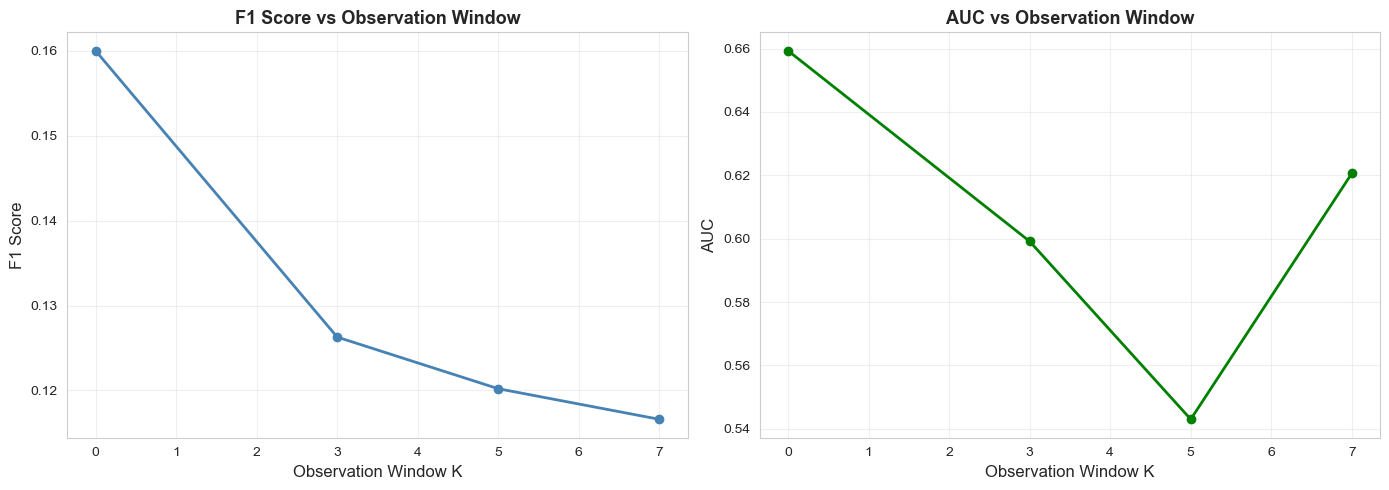

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score
ax = axes[0]
f1_scores = [results[K]['test']['f1'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], f1_scores, marker='o', linewidth=2, color='steelblue')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
auc_scores = [results[K]['test']['auc'] for K in CONFIG['observation_windows']]
ax.plot(CONFIG['observation_windows'], auc_scores, marker='o', linewidth=2, color='green')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()